# Scraping weather data from Environment Canada website

This notebook shows my exploratory process to develop code for downloading weather data (past 24 hours data for an airport weather station) and scraping the HTML to extract and parse the data into a `pandas` dataframe. 

I'm using the `requests` library read the web page, the Beautiful Soup library (`bs4`) to parse the HTML, the regular expressions library (`re`) to parse data from text, and the `pandas` library to organize the data into a dataframe.

After this exploratory process, I consolidated the code into a script `ecweather.py` that can be run from the Anaconda prompt (or other command line terminal) with `python ecweather.py output_file.csv`.

In [1]:
import bs4
import numpy as np
import pandas as pd
import requests
import re

from ipywidgets import interact
from IPython.display import display

%matplotlib inline

## Read HTML file from web page

In [2]:
def open_url(url, headers=None):
    """Read url and return as BeautifulSoup object."""
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    return soup

In [3]:
station_code = 'yfc'
#station_code = 'yvr'
#station_code = 'yxe'
url = f'https://weather.gc.ca/past_conditions/index_e.html?station={station_code}'
soup = open_url(url)

# Display the first 1000 characters of the HTML document
soup.prettify()[:1000]

'<!DOCTYPE html>\n<!--[if lt IE 9]><html class="no-js lt-ie9" lang="en" dir="ltr"><![endif]-->\n<!--[if gt IE 8]><!-->\n<html class="no-js" dir="ltr" lang="en">\n <!--<![endif]-->\n <head>\n  <meta charset="utf-8"/>\n  <!-- Web Experience Toolkit (WET) / BoÃ®te Ã\xa0 outils de l\'expÃ©rience Web (BOEW)\r\n\t\twet-boew.github.io/wet-boew/License-en.html / wet-boew.github.io/wet-boew/Licence-fr.html -->\n  <meta content="width=device-width, initial-scale=1" name="viewport"/>\n  <meta content="Environment Canada" name="dcterms.creator"/>\n  <meta content="eng" name="dcterms.language" title="ISO639-2"/>\n  <meta content="Hourly weather conditions summary for the past 24 hours.  This includes conditions, temperature, humidity, dew point, wind speed/direction, air pressure, visibility, and wind chill/humidex (when applicable)" name="description"/>\n  <meta content="Weather; Meteorology; Climate; Weather Forecasts; Trends" name="dcterms.subject" title="scheme"/>\n  <meta content="2013-04-16" 

## Parse data from HTML

### Extract station information from the page title and body

In [4]:
def parse_station_name(soup):
    """Return the station name parsed from html document title"""
    remove = ' - Past 24 Hour Conditions - Environment Canada'
    station_name = soup.title.text.replace(remove, '').strip()
    
    # Hacky workaround to handle accented e in Montreal
    station_name = station_name.encode('ascii', 'replace').decode('utf-8')
    station_name = station_name.replace('??', 'e')
    
    return station_name

In [5]:
station_name = parse_station_name(soup)
station_name

"Fredericton Int'l Airport"

In [6]:
def parse_latlon(soup):
    """Return lat, lon parsed from html document"""
    coords = {}
    for nm in ['Latitude', 'Longitude']:
        regex = nm + ' [0-9]*.[0-9]*'
        matches = re.findall(regex, soup.text)
        if len(matches) == 0:
            raise ValueError('Unable to find latitude')
        coords[nm] = float(matches[0].split(' ')[1].strip())
   
    # Longitude for all Canadian stations is deg W so convert to negative value
    coords['Longitude'] = -1 * coords['Longitude']
    return coords

In [7]:
coords = parse_latlon(soup)
coords

{'Latitude': 45.87, 'Longitude': -66.54}

### Find the table containing hourly weather data

In [8]:
items = soup.findAll('div', {'id' : 'table-container'})
table = items[0]
rows = table.find_all('tr')
nrows = len(rows)
print(f'Table with {nrows} rows')

Table with 28 rows


#### Use an interactive widget to explore each row of the table

This `interact` widget comes from the `ipywidgets` library, which is not included with the standard Anaconda distribution. To install `ipywidgets`, run the following command at the Anaconda prompt:
```
conda install -c conda-forge ipywidgets
```

In [9]:
# Explore table rows with interactive widget

@interact(row_number=(0, nrows - 1))
def show_row(row_number):
    row = rows[row_number]

    # First look for header row
    items = row.find_all('th')

    # If not a header row, look for body row
    if len(items) == 0:
        items = row.find_all('td')
    print(items)

interactive(children=(IntSlider(value=13, description='row_number', max=27), Output()), _dom_classes=('widget-interact',))

#### Types of rows in the table

From the above exploration, we can see that there are three types of rows in the data table:

- Main header: `<th class="wxo-tb-head vertical-center">`
- Date header: `<th class="wxo-th-bkg table-date">`
- Body row `<td class="text-center vertical-center">`

### Initial parsing of data from the table rows

In [10]:
def parse_row(row):
    """Return a list of items in the row, with some additional processing to clean the text data"""
    
    # First look for header rows
    entries = row.find_all('th')
    
     # Then look for table body rows
    if len(entries) == 0:
        entries = row.find_all('td')
        
    # List of items with extra whitespace stripped from exterior and interior of each string
    items = [re.sub(r'\s+', ' ', entry.text.strip()) for entry in entries]
    
    # Remove non-ascii characters from column names
    items = [item.encode('ascii', 'ignore').decode('utf-8') for item in items]
     
    return items

In [11]:
def parse_timezone_code(label):
    """Parse date/time label in table header for the 3-letter timezone code"""
    matches = re.findall('\(.*\)', label)
    if len(matches) == 0:
        raise ValueError(f'Cannot find timezone in {label}')
    timezone = matches[0].replace('(', '').replace(')', '')
    return timezone

In [12]:
def get_timezone(timezone_code):
    """Return timezone name for 3-letter timezone codes"""
    regions = ['Atlantic', 'Central', 'Eastern', 'Mountain', 'Newfoundland',
               'Pacific', 'Yukon']
    tz_dict = {}
    for region in regions:
        tz_dict[region[0] + 'ST'] = 'Canada/' + region
        tz_dict[region[0] + 'DT'] = 'Canada/' + region

    return tz_dict.get(timezone_code)

#### Wrangle data with lists

Create a nested list of the data in a preliminary form, where each item in the list is itself a list containing the items in a table row, with some some parsing and cleaning of the data

In [13]:
# Nested list of data

data_list = []
date_str = ''
header = ['Date'] + parse_row(rows[0])

# Deal with wonky labels for humidex columns
if 'Humidex' in header:
    ind = header.index('Humidex')
    header[ind] = 'Humidex (C)'
if 'Humidex' in header:
    ind2 = header.index('Humidex')
    header[ind2] = 'Humidex (F)'

timezone_code = parse_timezone_code(header[1])
timezone = get_timezone(timezone_code)
for row in rows[1:]:
    items = parse_row(row)
    if len(items) == 1:
        # Date header - incorporate as column in the data
        date_str = items[0]
    else:
        data_list.append([date_str] + items)

print(header)
data_list

['Date', 'Date / Time(ADT)', 'Conditions', 'Temperature (C)', 'Temperature (F)', 'Wind(km/h)', 'Wind(mph)', 'Relativehumidity(%)', 'Dew point(C)', 'Dew point(F)', 'Pressure(kPa)', 'Pressure(inches)', 'Visibility (km)', 'Visibility (mi)']


[['23 May 2018',
  '01:00',
  'Cloudy',
  '14  (13.9)',
  '57  (57.0)',
  'SSW 17',
  'SSW 10',
  '68',
  '8',
  '47',
  '101.2',
  '29.9',
  '16',
  '10'],
 ['23 May 2018',
  '00:00',
  'Cloudy',
  '14  (13.9)',
  '57  (57.0)',
  'SSW 18',
  'SSW 11',
  '66',
  '8',
  '46',
  '101.2',
  '29.9',
  '16',
  '10'],
 ['22 May 2018',
  '23:00',
  'Mostly Cloudy',
  '14  (14.0)',
  '57  (57.2)',
  'SSW 24 gust 34',
  'SSW 15 gust 21',
  '63',
  '7',
  '45',
  '101.3',
  '29.9',
  '16',
  '10'],
 ['22 May 2018',
  '22:00',
  'Mainly Clear',
  '14  (14.3)',
  '58  (57.7)',
  'SSW 21 gust 30',
  'SSW 13 gust 18',
  '59',
  '7',
  '44',
  '101.4',
  '29.9',
  '16',
  '10'],
 ['22 May 2018',
  '21:00',
  'Partly Cloudy',
  '16  (16.0)',
  '61  (60.8)',
  'S 21 gust 34',
  'S 13 gust 21',
  '48',
  '5',
  '41',
  '101.4',
  '29.9',
  '16',
  '10'],
 ['22 May 2018',
  '20:00',
  'Mostly Cloudy',
  '18  (17.6)',
  '64  (63.7)',
  'S 22 gust 37',
  'S 14 gust 23',
  '37',
  '3',
  '37',
  '101.5',
  

In [14]:
print(f'Timezone: {timezone} ({timezone_code})')

Timezone: Canada/Atlantic (ADT)


### Wrangle the data into a dataframe

Perform some parsing of the data and remove unnecessary columns

In [15]:
def parse_temperature(temp_str):
    """Return temperature value parsed from temperature string"""
    if temp_str.lower() == 'n/a' or temp_str.lower() == 'na':
        return None
    matches = re.findall('\(.*\)', temp_str)
    if len(matches) == 0:
        raise ValueError(f'Input {temp_str} does not match expected format')
    temp = float(matches[0].replace('(', '').replace(')', ''))
    return temp

In [16]:
def parse_wind(wind_str):
    """Return wind direction and wind speed parsed from wind string"""
    if wind_str.lower() == 'n/a' or wind_str.lower() == 'na':
        return pd.Series([np.nan, np.nan], index=['Wind Direction', 'Wind Speed (km/hr)'])
    parts = wind_str.split(' ')
    if len(parts) == 1 and parts[0] == 'calm':
        wind_dir = None
        wind_speed = 0
    elif len(parts) >= 0:
        wind_dir = parts[0].strip()
        wind_speed = float(parts[1].strip())
    else:
        raise ValueError(f'Unable to parse wind {wind_str}')
    series = pd.Series([wind_dir, wind_speed], index=['Wind Direction', 'Wind Speed (km/hr)'])
    return series

In [17]:
def imperial_units(label):
    """Return True if the label identifies a variable in Imperial units"""
    imperial = False
    for nm in ['(F)', '(inches)', '(mph)', '(mi)']:
        if label.endswith(nm):
            imperial = True
            break
    return imperial

I initially developed the code below as a series of separate cells, corresponding to each stage of the data processing, so that I could look at the output at each step along the way. Once I'd finished this process, I consolidated all the cells into the single large cell below. I did this because modifying a variable (in this case the dataframe `data`) in different Jupyter notebook cells can be error prone due to the non-linear nature of the notebook environment. If I modify `data` and then jump back to a previous cell and execute the code, I could cause errors or modify the variable in unexpected ways that were not what I intended. For this reason, I always try to consolidate any modifications to a variable into a single cell after I've finished my initial exploratory process.

In [18]:
# Create dataframe
data = pd.DataFrame(data_list, columns=header)

print('\nInitial dataframe\n')
display(data.head(3))

# Remove columns with imperial measurements
cols_remove = [col for col in data.columns if imperial_units(col)]
data = data.drop(cols_remove, axis=1)

print('\nDropped extra columns\n')
display(data.head(3))

# Parse temperature strings
data['Temperature (C)'] = data['Temperature (C)'].apply(parse_temperature)

# Parse dates and set index to datetime
dt_format = '%d %b %Y %H:%M'
time_col = header[1]
times = pd.to_datetime(data['Date'] + ' ' + data[time_col], format=dt_format)
#times = pd.DatetimeIndex(times, tz=timezone)
data = data.set_index(times)
data.index.name = 'Datetime'
data = data.drop(['Date', time_col], axis=1)

# Parse wind data into separation columns for wind direction and speed
data = data.join(data['Wind(km/h)'].apply(parse_wind))
data = data.drop('Wind(km/h)', axis=1)

# Drop the extra hour at the end, so that the dataframe is 24 hours long
data = data[:24]

# Reverse the row order so that time is increasing down the table
data = data.iloc[::-1, :]
    
# Add station code, station name, lat, lon, timezone, and hour of day
columns = list(data.columns)
data['Station ID'] = station_code.upper()
data['Station Name'] = station_name
data['Latitude'] = coords['Latitude']
data['Longitude'] = coords['Longitude']
data['Timezone'] = timezone
data['Hour of Day'] = data.index.hour
columns = ['Station ID', 'Station Name', 'Latitude', 'Longitude', 'Timezone', 'Hour of Day'] + columns
data = data[columns]

print('\nFinal dataframe')
print(data.shape)
data


Initial dataframe



,Date,Date / Time(ADT),Conditions,Temperature (C),Temperature (F),Wind(km/h),Wind(mph),Relativehumidity(%),Dew point(C),Dew point(F),Pressure(kPa),Pressure(inches),Visibility (km),Visibility (mi)
0,23 May 2018,01:00,Cloudy,14 (13.9),57 (57.0),SSW 17,SSW 10,68,8,47,101.2,29.9,16,10
1,23 May 2018,00:00,Cloudy,14 (13.9),57 (57.0),SSW 18,SSW 11,66,8,46,101.2,29.9,16,10
2,22 May 2018,23:00,Mostly Cloudy,14 (14.0),57 (57.2),SSW 24 gust 34,SSW 15 gust 21,63,7,45,101.3,29.9,16,10



Dropped extra columns



,Date,Date / Time(ADT),Conditions,Temperature (C),Wind(km/h),Relativehumidity(%),Dew point(C),Pressure(kPa),Visibility (km)
0,23 May 2018,01:00,Cloudy,14 (13.9),SSW 17,68,8,101.2,16
1,23 May 2018,00:00,Cloudy,14 (13.9),SSW 18,66,8,101.2,16
2,22 May 2018,23:00,Mostly Cloudy,14 (14.0),SSW 24 gust 34,63,7,101.3,16



Final dataframe
(24, 14)


,Station ID,Station Name,Latitude,Longitude,Timezone,Hour of Day,Conditions,Temperature (C),Relativehumidity(%),Dew point(C),Pressure(kPa),Visibility (km),Wind Direction,Wind Speed (km/hr)
Datetime,,,,,,,,,,,,,,
2018-05-22 02:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,2,Clear,4.8,68,-1,102.0,16,NaN,0.0
2018-05-22 03:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,3,Clear,3.1,81,0,102.0,16,NW,5.0
2018-05-22 04:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,4,Clear,2.6,83,0,102.1,16,NNW,5.0
2018-05-22 05:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,5,Clear,1.8,87,0,102.2,16,SW,4.0
2018-05-22 06:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,6,Sunny,0.7,96,0,102.2,16,WSW,5.0
2018-05-22 07:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,7,Sunny,3.7,89,2,102.2,16,WNW,4.0
2018-05-22 08:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,8,Sunny,7.2,69,2,102.3,16,NaN,0.0
2018-05-22 09:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,9,Sunny,10.0,57,2,102.2,16,SSW,4.0
2018-05-22 10:00:00,YFC,Fredericton Int'l Airport,45.87,-66.54,Canada/Atlantic,10,Sunny,13.5,41,1,102.2,16,S,9.0


## Explore the data a bit

In [19]:
data.describe()

,Latitude,Longitude,Hour of Day,Temperature (C),Wind Speed (km/hr)
count,24.00,2.400000e+01,24.000000,23.000000,23.000000
mean,45.87,-6.654000e+01,11.500000,12.973913,16.260870
std,0.00,2.903300e-14,7.071068,7.216787,11.185288
min,45.87,-6.654000e+01,0.000000,0.700000,0.000000
25%,45.87,-6.654000e+01,5.750000,6.000000,5.000000
50%,45.87,-6.654000e+01,11.500000,14.000000,18.000000
75%,45.87,-6.654000e+01,17.250000,18.950000,23.000000
max,45.87,-6.654000e+01,23.000000,21.800000,35.000000


In [20]:
data['Conditions'].value_counts()

Sunny            12
Clear             4
Mostly Cloudy     2
Cloudy            2
n/a               1
Partly Cloudy     1
Mainly Clear      1
Mainly Sunny      1
Name: Conditions, dtype: int64

In [21]:
data['Wind Direction'].value_counts()

SSW    10
S       5
SW      2
WSW     1
WNW     1
NW      1
NNW     1
Name: Wind Direction, dtype: int64

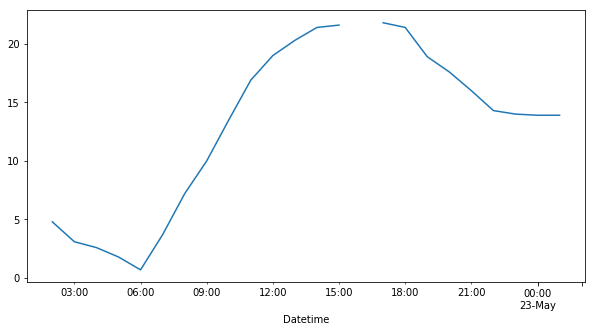

In [22]:
data['Temperature (C)'].plot.line(figsize=(10, 5))